In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, cohen_kappa_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

In [2]:
# Parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
REDUCED_SAMPLES_PER_CLASS = 2000
epochs = 20
learning_rate = 3.9e-5
num_classes = 5
folder_path = './../../datasets/dataset1'


# Function to load and preprocess images
def preprocess_image(img_path, img_height, img_width):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [img_height, img_width])
    img = img / 255.0
    return img

# Function to create TensorFlow dataset
def create_dataset(image_paths, labels, img_height, img_width, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x, img_height, img_width), y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  # Improve performance
    return dataset

# Function to get image paths and labels with specific sampling for class 0 and 2
def get_image_paths_and_labels(directory, reduced_samples_per_class):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(directory))
    class_to_index = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_folder = os.path.join(directory, class_name)
        if os.path.isdir(class_folder):
            class_images = [os.path.join(class_folder, filename) for filename in os.listdir(class_folder)]
            if class_name in ['0', '2']:  # Reduce images to 3000 for class 0 and 2
                class_images = np.random.choice(class_images, reduced_samples_per_class, replace=False)
            image_paths.extend(class_images)
            labels.extend([class_to_index[class_name]] * len(class_images))
    
    return image_paths, labels

# Load image paths and labels
image_paths, labels = get_image_paths_and_labels(folder_path, REDUCED_SAMPLES_PER_CLASS)

# Convert labels to NumPy array
labels = np.array(labels).reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
labels_onehot = encoder.fit_transform(labels)

# Create TensorFlow dataset
dataset = create_dataset(image_paths, labels_onehot, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE)

# Split the dataset into train, validation, and test sets using scikit-learn
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels_onehot, test_size=0.4, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Create TensorFlow datasets for training, validation, and testing
train_dataset = create_dataset(X_train, y_train, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE)
val_dataset = create_dataset(X_val, y_val, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE)
test_dataset = create_dataset(X_test, y_test, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE)

In [5]:
def balanced_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(
        func=lambda y_true, y_pred: balanced_accuracy_score(
            y_true.numpy(), y_pred.numpy()),
        inp=[y_true, y_pred],
        Tout=tf.float64)


def fscore(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=1), tf.int32)

    def compute_fscore(y_true, y_pred):
        _, _, fscore, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0)
        return fscore

    return tf.py_function(func=compute_fscore, inp=[y_true, y_pred], Tout=tf.float64)

# Custom Kappa Metric
def kappa_score(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    kappa_score = tf.py_function(func=cohen_kappa_score, inp=[y_true, y_pred], Tout=tf.float32)
    return kappa_score

In [6]:

metrics = [
    'accuracy',
    tf.keras.metrics.AUC(),
    balanced_accuracy,
    fscore,
    kappa_score,
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

In [7]:
import warnings
warnings.filterwarnings('ignore', message="A single label was found in y_true and y_pred.")
warnings.filterwarnings('ignore', message="y_pred contains classes not in y_true") 
warnings.filterwarnings('ignore', message="A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.") 


def accuracyGraph(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    print ('train_accuracy-> ', train_accuracy)
    print ('val_accuracy-> ', val_accuracy)
    print ('train_loss-> ', train_loss)
    print ('val_loss-> ', val_loss)

    epochs_no = range(len(train_accuracy) + 1)


    # Plot accuracy
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_no, [0] + train_accuracy, 'b', label='Train Accuracy')
    plt.plot(epochs_no, [0] + val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_no, [0] + train_loss, 'b', label='Train Loss')
    plt.plot(epochs_no, [0] + val_loss, 'r', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 3)
    plt.plot(epochs_no, [0] + val_accuracy, 'b')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs_no, [0] + val_loss, 'r')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()
    
def show_confusion_matrix(model):
    # Get true labels and predictions
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Generate classification report
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)]))
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)

    # Plot confusion matrix
    def plot_confusion_matrix(cm, class_names):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()

    plot_confusion_matrix(conf_matrix, [str(i) for i in range(num_classes)])
    

In [8]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [9]:
# Compile the model with the custom loss function
model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=metrics)
print(model.summary())


# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=BATCH_SIZE
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

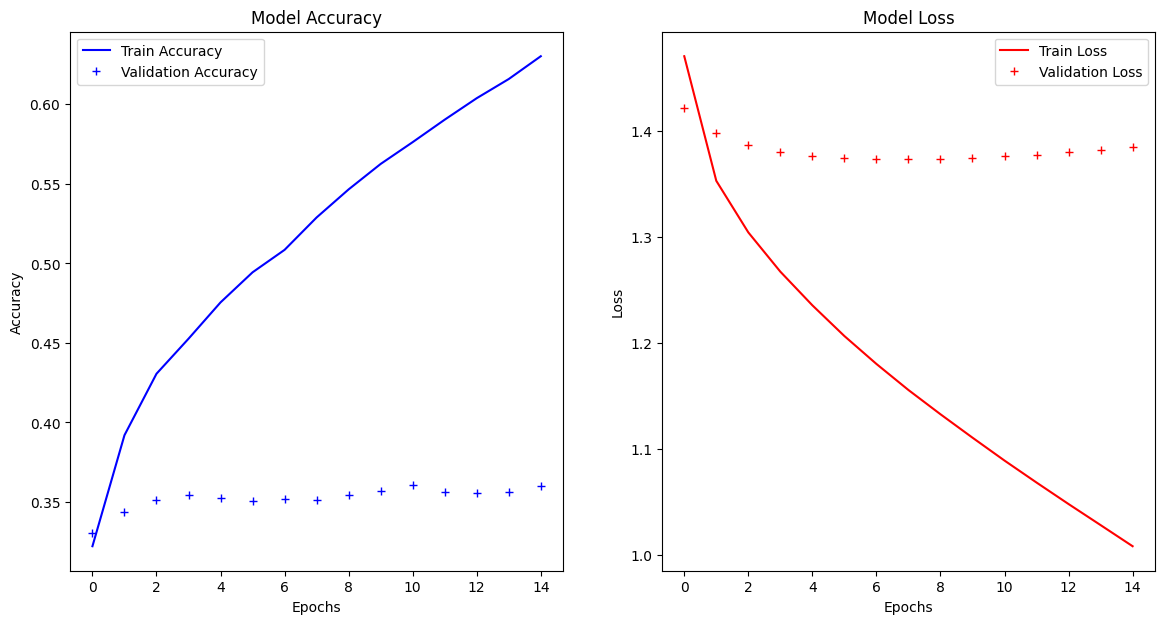

In [10]:
accuracyGraph(history)

1/1 [==============================] - 1s 772ms/step
              precision    recall  f1-score   support

           0       0.32      0.32      0.32       400
           1       0.42      0.53      0.47       489
           2       0.34      0.24      0.28       400
           3       0.42      0.41      0.41       174
           4       0.53      0.50      0.51       142

    accuracy                           0.39      1605
   macro avg       0.41      0.40      0.40      1605
weighted avg       0.39      0.39      0.38      1605

[[127 179  62  13  19]
 [133 261  71  19   5]
 [102 138  96  45  19]
 [ 23  35  23  72  21]
 [  9  10  28  24  71]]


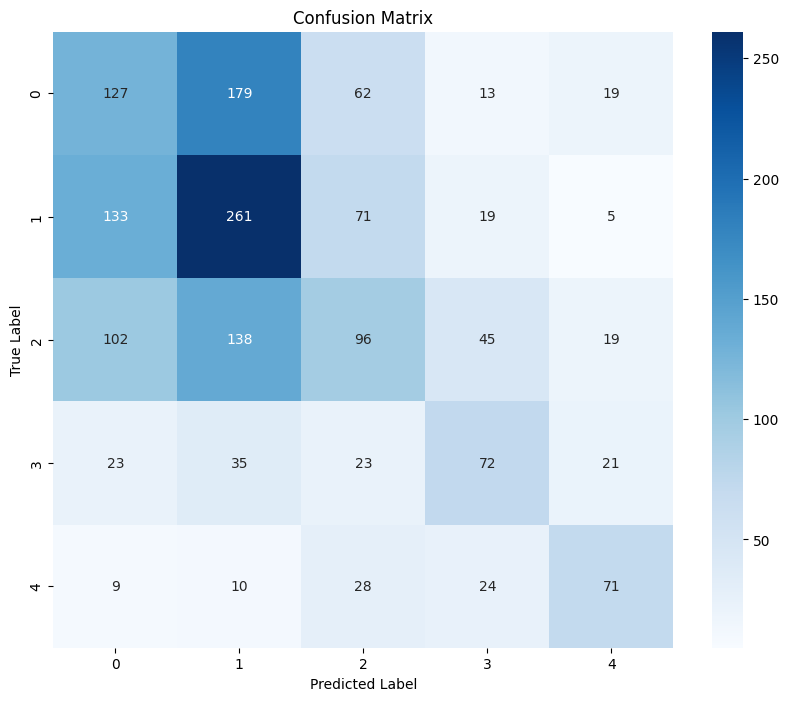

In [11]:
show_confusion_matrix(model)

In [12]:
_metrices = model.evaluate(test_dataset)
print("Test Metrices", _metrices)

51/51 [==============================] - 3s 50ms/step - loss: 1.3493 - accuracy: 0.3907 - auc: 0.7489 - balanced_accuracy: 0.3848 - fscore: 0.3681 - kappa_score: 0.1777 - precision: 0.4794 - recall: 0.1520
Test Metrices [1.3492540121078491, 0.39065420627593994, 0.7488604784011841, 0.3847563564777374, 0.3680584132671356, 0.1777341514825821, 0.4793713092803955, 0.15202492475509644]


In [13]:


x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tuning: Unfreeze some layers of the base model
for layer in base_model.layers[:249]:  # Adjust the index as needed
    layer.trainable = False
for layer in base_model.layers[249:]:
    layer.trainable = True


# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(lr=learning_rate), loss="categorical_crossentropy", metrics=metrics)

# Continue training (fine-tuning)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=BATCH_SIZE
)

Epoch 1/15


c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


151/151 [==============================] - 16s 81ms/step - loss: 1.4529 - accuracy: 0.3299 - auc: 0.7041 - balanced_accuracy: 0.2901 - fscore: 0.2546 - kappa_score: 0.0963 - precision: 0.4787 - recall: 0.0525 - val_loss: 1.3784 - val_accuracy: 0.3620 - val_auc: 0.7266 - val_balanced_accuracy: 0.3033 - val_fscore: 0.2740 - val_kappa_score: 0.1198 - val_precision: 0.4184 - val_recall: 0.0368
Epoch 2/15
151/151 [==============================] - 11s 74ms/step - loss: 1.1628 - accuracy: 0.5164 - auc: 0.8294 - balanced_accuracy: 0.5035 - fscore: 0.4775 - kappa_score: 0.3513 - precision: 0.7249 - recall: 0.1757 - val_loss: 1.3521 - val_accuracy: 0.3844 - val_auc: 0.7466 - val_balanced_accuracy: 0.3543 - val_fscore: 0.3323 - val_kappa_score: 0.1654 - val_precision: 0.4659 - val_recall: 0.1445
Epoch 3/15
151/151 [==============================] - 11s 75ms/step - loss: 0.7190 - accuracy: 0.7570 - auc: 0.9491 - balanced_accuracy: 0.7461 - fscore: 0.7240 - kappa_score: 0.6763 - precision: 0.8864 

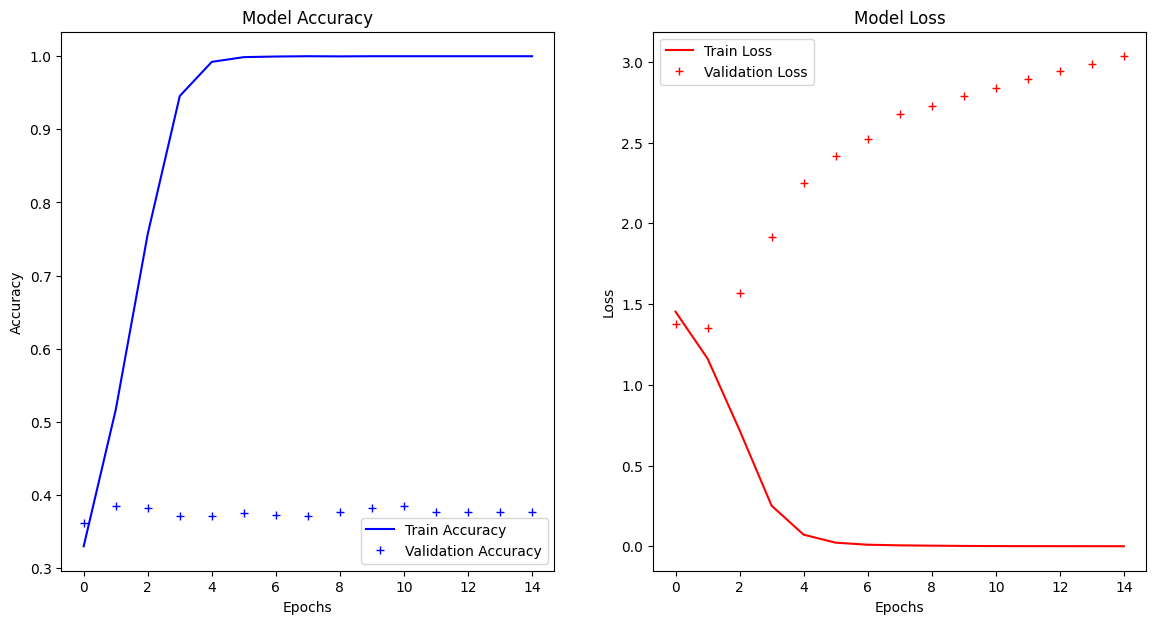

In [14]:
accuracyGraph(history)

1/1 [==============================] - 1s 778ms/step
              precision    recall  f1-score   support

           0       0.34      0.32      0.33       400
           1       0.39      0.42      0.40       489
           2       0.33      0.33      0.33       400
           3       0.42      0.40      0.41       174
           4       0.64      0.58      0.61       142

    accuracy                           0.38      1605
   macro avg       0.42      0.41      0.42      1605
weighted avg       0.39      0.38      0.38      1605

[[129 158  87  15  11]
 [145 205 118  18   3]
 [ 80 130 131  42  17]
 [ 18  25  47  69  15]
 [  9  11  20  20  82]]


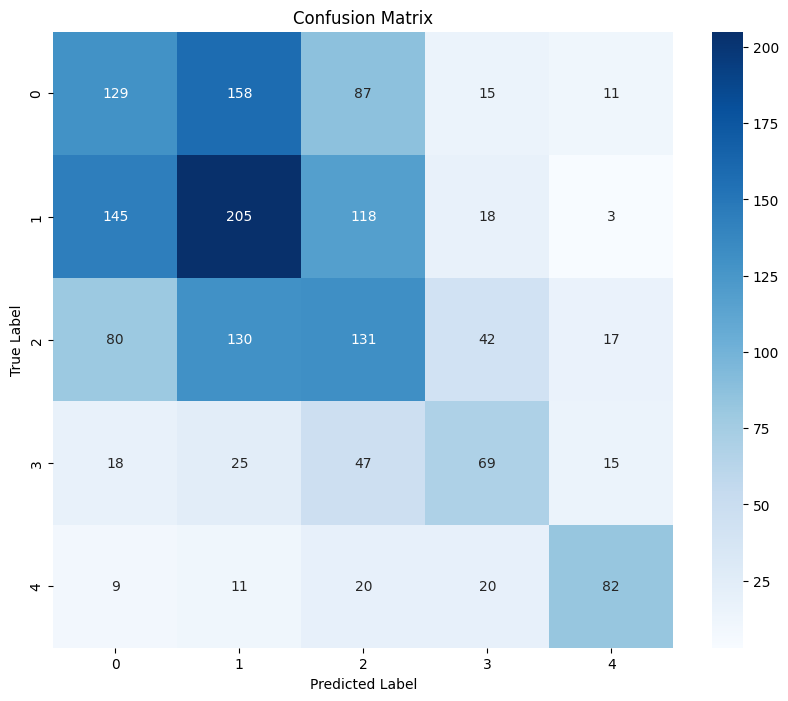

In [15]:
show_confusion_matrix(model)

In [16]:
_metrices = model.evaluate(test_dataset)
print("Test Metrices", _metrices)

51/51 [==============================] - 3s 49ms/step - loss: 2.9586 - accuracy: 0.3838 - auc: 0.6944 - balanced_accuracy: 0.4012 - fscore: 0.3826 - kappa_score: 0.1737 - precision: 0.3911 - recall: 0.3657
Test Metrices [2.95858097076416, 0.3838006258010864, 0.6943923830986023, 0.4011552333831787, 0.38258495926856995, 0.17371045053005219, 0.3910726308822632, 0.3657320737838745]
